In [1]:
import numpy as np
from exp_family import *
from projectors import *

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

In [2]:
def sgd(objective, sample_dist, zero_point, projector, strong_convexity_coef = None, 
        C = 1, problem = "KL", acceleration = False, max_iter = 10**5):
    cur_theta = zero_point
    estim = []
    thetas = [cur_theta]
    dim = len(zero_point[0])
    if strong_convexity_coef != None:
        lam = strong_convexity_coef
    else:
        acceleration = False
        lam = 0
    for i in range(max_iter):
        f_theta = sample_dist(*cur_theta)
        cur_x = f_theta.sample()
        # estimation part
        x = cur_x
        tmp = objective(x)/f_theta.pdf(x)
        if i == 0:
            cur_estim = tmp
        else:
            #print(estim)
            cur_estim = tmp + estim[i - 1] * i
            cur_estim = cur_estim/(i + 1)
        estim.append(cur_estim)
        # gradient part
        if problem == "KL":
            grad = tuple((g_A - t)*tmp for g_A, t in zip(f_theta.grad_A(),f_theta.T(x)))
            coef = lam**2/2
        elif problem == "Var":
            grad = tuple((g_A - t)*(tmp**2) for g_A, t in zip(f_theta.grad_A(),f_theta.T(x)))
            coef = lam**(2 + dim/2)/2
        else:
            raise ValueError('problem should be equal to either "KL" or "Var"')
        # step part
        if acceleration:
            if i == 0:
                print('here')
            step_size = C/(coef*(i+1))
        else:
            step_size = C/np.sqrt(i+1)
            #step_size = C
        cur_theta = tuple(theta_elem - step_size*g for theta_elem, g in zip(cur_theta, grad))
        cur_theta = projector(*cur_theta)
        thetas.append(cur_theta)
    return estim, thetas

In [3]:
obj = lambda x: x.dot(x) <= 4
l_min = 1e-1
l_max = 1
zero_point = (np.array([0,0]), np.eye(2))
projector = CoordProjector(BoxProjector(-1, 1), EigenBoxProjector(l_min, l_max))

### Estimations using KL-divergence without acceleration

In [4]:
estim0, thetas0 = sgd(obj, GaussianDistribution, zero_point, projector, max_iter=10**6, C=1e-1)

In [5]:
thetas0[::10000]

[(array([0, 0]), array([[ 1.,  0.],
         [ 0.,  1.]])),
 (array([ 0.20607834,  0.02775933]), array([[ 0.9262597 , -0.03932301],
         [-0.03932301,  0.97378289]])),
 (array([-0.06790799, -0.09276641]), array([[ 0.87595099, -0.03146051],
         [-0.03146051,  0.9883867 ]])),
 (array([-0.01352779, -0.01877807]), array([[ 0.95152583,  0.03609024],
         [ 0.03609024,  0.94807286]])),
 (array([-0.15909159,  0.04847102]), array([[ 0.94457686, -0.02024553],
         [-0.02024553,  0.96800361]])),
 (array([-0.11615671, -0.03245266]), array([[ 0.99992631, -0.0014663 ],
         [-0.0014663 ,  0.97082494]])),
 (array([-0.08805082, -0.01950791]), array([[ 0.93828278,  0.05544789],
         [ 0.05544789,  0.92663711]])),
 (array([-0.07058223,  0.0169497 ]), array([[ 0.95876925,  0.00170212],
         [ 0.00170212,  0.92493896]])),
 (array([-0.04230932,  0.0423177 ]), array([[ 0.92264984, -0.01557842],
         [-0.01557842,  0.98413725]])),
 (array([-0.04633568,  0.04428432]), array([

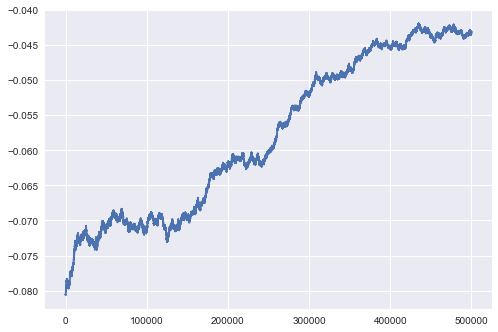

In [6]:
true_value = np.pi*4
plt.plot(np.array(estim0)[50*10**4:] - true_value)

### Estimations using KL-divergence with acceleration

In [7]:
estim1, thetas1 = sgd(obj, GaussianDistribution, zero_point, projector, max_iter=10**6, C=1, strong_convexity_coef = 1/l_max, acceleration = True)

here


In [8]:
thetas1[::10000]

[(array([0, 0]), array([[ 1.,  0.],
         [ 0.,  1.]])),
 (array([-0.08675179,  0.02828016]),
  array([[  9.82285816e-01,  -7.68379217e-04],
         [ -7.68379217e-04,   9.72157026e-01]])),
 (array([-0.02396375, -0.02214042]), array([[ 0.99081084,  0.00569513],
         [ 0.00569513,  0.98775461]])),
 (array([ 0.04462186,  0.00021397]), array([[ 0.99794742, -0.00950536],
         [-0.00950536,  0.95598128]])),
 (array([-0.0233129,  0.009528 ]), array([[ 0.99682393,  0.00856554],
         [ 0.00856554,  0.96954087]])),
 (array([-0.00311138,  0.01332359]), array([[ 0.9988591 ,  0.0050386 ],
         [ 0.0050386 ,  0.96525928]])),
 (array([ 0.03911185, -0.0544161 ]), array([[ 0.9858905 , -0.00750232],
         [-0.00750232,  0.97923942]])),
 (array([ 0.00891492,  0.01352423]), array([[ 0.97613565, -0.0053913 ],
         [-0.0053913 ,  0.99082124]])),
 (array([-0.01645488,  0.00421115]), array([[ 0.98728372, -0.00509801],
         [-0.00509801,  0.98262187]])),
 (array([-0.0081378 , -0

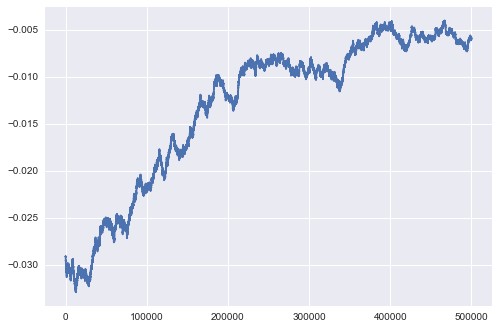

In [10]:
true_value = np.pi*4
plt.plot(np.array(estim1)[5*10**5:] - true_value)

### Estimations using variance without acceleration

In [18]:
estim2, thetas2 = sgd(obj, GaussianDistribution, zero_point, projector, max_iter=10**6, C=1e-2, problem='Var')

In [19]:
thetas2[::10000]

[(array([0, 0]), array([[ 1.,  0.],
         [ 0.,  1.]])), (array([ 1.,  1.]), array([[ 0.5223451 , -0.44914943],
         [-0.44914943,  0.5776549 ]])), (array([ 1.,  1.]),
  array([[ 0.5223451 , -0.44914943],
         [-0.44914943,  0.5776549 ]])), (array([ 1.,  1.]),
  array([[ 0.5223451 , -0.44914943],
         [-0.44914943,  0.5776549 ]])), (array([ 0.08199802,  0.10517922]),
  array([[ 0.84342521,  0.08443451],
         [ 0.08443451,  0.86557109]])), (array([-0.10041905, -0.03609694]),
  array([[ 0.98647593,  0.02594996],
         [ 0.02594996,  0.73514829]])), (array([-0.08947477,  0.1469507 ]),
  array([[ 0.79108636, -0.14310229],
         [-0.14310229,  0.77127761]])), (array([ 0.00592737, -0.14454544]),
  array([[ 0.72243285,  0.00516458],
         [ 0.00516458,  0.78989509]])), (array([ 0.00735898, -0.06787023]),
  array([[ 0.76333593, -0.09353256],
         [-0.09353256,  0.83943707]])), (array([ 0.00513328, -0.14944633]),
  array([[ 0.78878586,  0.003703  ],
         [ 0.

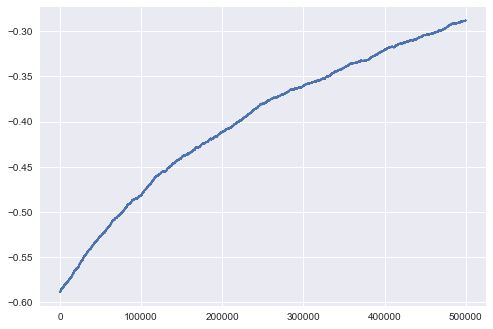

In [20]:
true_value = np.pi*4
plt.plot(np.array(estim2)[5*10**5:] - true_value)

### Estimations using variance with acceleration

In [21]:
estim3, thetas3 = sgd(obj, GaussianDistribution, zero_point, projector, 
                      max_iter=10**6, C=1e-1, problem='Var', strong_convexity_coef = 1/l_max, acceleration = True)

here


In [22]:
thetas3[::10000]

[(array([0, 0]), array([[ 1.,  0.],
         [ 0.,  1.]])),
 (array([-0.0300079 , -0.03479151]), array([[ 0.76484072,  0.02070216],
         [ 0.02070216,  0.78135873]])),
 (array([-0.02195137, -0.00183543]), array([[ 0.80661187,  0.04670682],
         [ 0.04670682,  0.79771202]])),
 (array([ 0.03663293, -0.02890192]), array([[ 0.79205927,  0.0020135 ],
         [ 0.0020135 ,  0.83785386]])),
 (array([ 0.00169754, -0.04670277]), array([[ 0.79174869, -0.03008991],
         [-0.03008991,  0.80438832]])),
 (array([ 0.01297741, -0.01903371]), array([[ 0.82218505, -0.0345748 ],
         [-0.0345748 ,  0.78439614]])),
 (array([-0.04541525,  0.04172183]), array([[ 0.82520582,  0.02728195],
         [ 0.02728195,  0.79932286]])),
 (array([-0.02662471,  0.03081689]),
  array([[  7.97970236e-01,  -2.95515823e-04],
         [ -2.95515823e-04,   7.90183414e-01]])),
 (array([ 0.01942784,  0.00962348]), array([[ 0.77330225, -0.00464813],
         [-0.00464813,  0.83168104]])),
 (array([-0.01127477, 

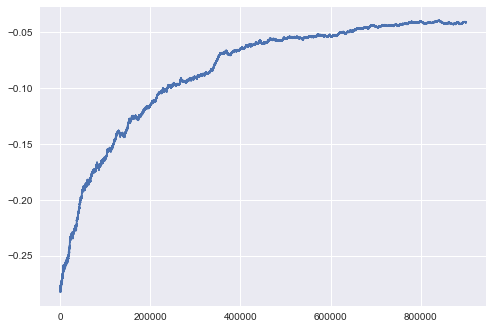

In [23]:
true_value = np.pi*4
plt.plot(np.array(estim3)[10**5:] - true_value)

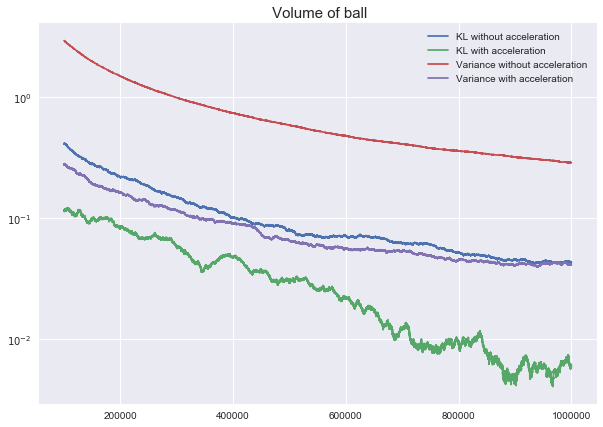

In [29]:
plt.figure(figsize=(10, 7))
plt.title(r" Volume of ball", # $\displaystyle x^TAx \le 4$
          fontsize=15)
plt.plot(np.arange(1e5, 1e6), np.fabs(np.array(estim0)[10**5:] - true_value), label = "KL without acceleration")
plt.plot(np.arange(1e5, 1e6), np.fabs(np.array(estim1)[10**5:] - true_value), label = "KL with acceleration")
plt.plot(np.arange(1e5, 1e6), np.fabs(np.array(estim2)[10**5:] - true_value), label = "Variance without acceleration")
plt.plot(np.arange(1e5, 1e6), np.fabs(np.array(estim3)[10**5:] - true_value), label = "Variance with acceleration")
plt.yscale('log')
plt.legend(loc = 'best')

plt.savefig('ball_sgd.png')

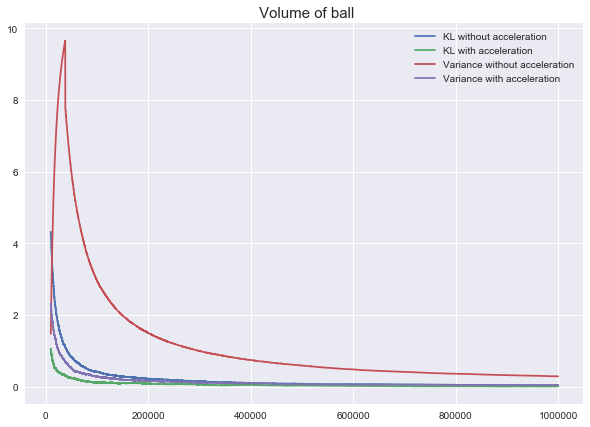

In [30]:
plt.figure(figsize=(10, 7))
plt.title(r" Volume of ball", # $\displaystyle x^TAx \le 4$
          fontsize=15)
plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim0)[10**4:] - true_value), label = "KL without acceleration")
plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim1)[10**4:] - true_value), label = "KL with acceleration")
plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim2)[10**4:] - true_value), label = "Variance without acceleration")
plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim3)[10**4:] - true_value), label = "Variance with acceleration")
#plt.yscale('log')
plt.legend(loc = 'best')

plt.savefig('ball_sgd1.png')

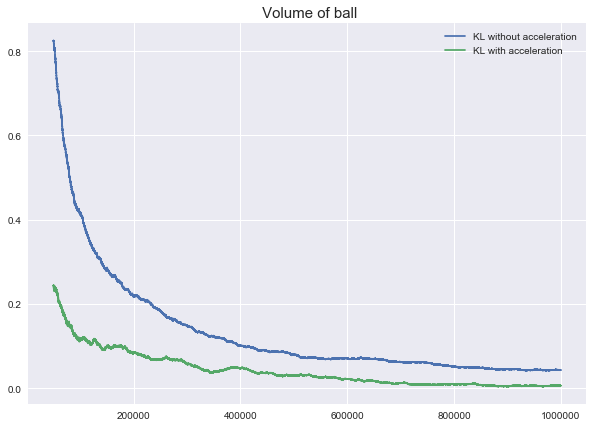

In [36]:
plt.figure(figsize=(10, 7))
plt.title(r" Volume of ball", # $\displaystyle x^TAx \le 4$
          fontsize=15)
plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim0)[5*10**4:] - true_value), label = "KL without acceleration")
plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim1)[5*10**4:] - true_value), label = "KL with acceleration")
#plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim2)[10**4:] - true_value), label = "Variance without acceleration")
#plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim3)[10**4:] - true_value), label = "Variance with acceleration")
#plt.yscale('log')
plt.legend(loc = 'best')

plt.savefig('ball_sgd2.png')

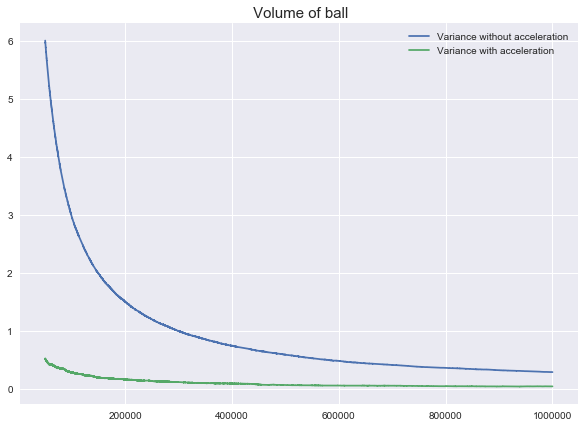

In [35]:
plt.figure(figsize=(10, 7))
plt.title(r" Volume of ball", # $\displaystyle x^TAx \le 4$
          fontsize=15)
#plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim0)[5*10**4:] - true_value), label = "KL without acceleration")
#plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim1)[5*10**4:] - true_value), label = "KL with acceleration")
plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim2)[5*10**4:] - true_value), label = "Variance without acceleration")
plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim3)[5*10**4:] - true_value), label = "Variance with acceleration")
#plt.yscale('log')
plt.legend(loc = 'best')

plt.savefig('ball_sgd3.png')